In [1]:
%load_ext autoreload
%autoreload 2

# Imports

In [2]:
import numpy as np
import jax
import jax.numpy as jnp
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import diffrax as dfx
from typing import List

from functools import partial
import os
import sys

jax.config.update('jax_platform_name', 'gpu')

if __package__ is None:

    module_path = os.path.abspath(os.path.join('..'))
    sys.path.append(module_path)

    __package__ = os.path.basename(module_path)


# jupyter nbconvert --to notebook --execute 23_Monte_Carlo_adaptability_2.ipynb --output=23_Monte_Carlo_adaptability_2_large.ipynb --ExecutePreprocessor.timeout=-1
np.random.seed(0)
jax.devices()

[cuda(id=0), cuda(id=1)]

In [3]:
from synbio_morpher.srv.parameter_prediction.simulator import make_piecewise_stepcontrol
from synbio_morpher.utils.misc.type_handling import flatten_listlike
from synbio_morpher.utils.modelling.physical import eqconstant_to_rates, equilibrium_constant_reparameterisation
from synbio_morpher.utils.modelling.deterministic import bioreaction_sim_dfx_expanded
from synbio_morpher.utils.modelling.solvers import get_diffrax_solver, make_stepsize_controller, simulate_steady_states
from synbio_morpher.utils.results.analytics.timeseries import calculate_adaptation, compute_peaks, compute_adaptability_full


# Set up test circuits

In [4]:
def make_species_bound(species_unbound):
    return sorted(set(flatten_listlike([['-'.join(sorted([x, y])) for x in species_unbound] for y in species_unbound])))


# RNA circuit settings
species_unbound = ['RNA_0', 'RNA_1', 'RNA_2']
species_bound = make_species_bound(species_unbound)
species = species_unbound + species_bound
species_signal = ['RNA_0']
species_output = ['RNA_2']
# species_output = ['RNA_1', 'RNA_2']
species_nonsignal = [s for s in species_unbound if s not in species_signal]
idxs_signal = np.array([species.index(s) for s in species_signal])
idxs_output = np.array([species.index(s) for s in species_output])
idxs_unbound = np.array([species.index(s) for s in species_unbound])
idxs_bound = np.array([species.index(s) for s in species_bound])
signal_onehot = np.array([1 if s in idxs_signal else 0 for s in np.arange(len(species))])

# Dynamic Simulation parameters
k_a = 0.00150958097
signal_target = 2
t0 = 0
t1 = 500
ts = np.linspace(t0, t1, 500)
tmax = 1000
dt0 = 0.005555558569638981
dt1_factor = 5
dt1 = dt0 * dt1_factor
max_steps = 16**4 * 10
use_sensitivity_func1 = False
sim_method = 'Dopri5'
stepsize_controller = 'adaptive'
threshold_steady_state = 0.01
batch_size = 500

# MC parameters
total_steps = 20
total_samples = 5000
choose_max = int(total_samples * 0.1)
diversity = 0.2  # Sensitivity max to add into next chosen circuits
mutation_scale = 0.1
n_circuits_display = 30
N0 = 200
y00 = np.array([[N0] * len(species_unbound) + [0] * len(species_bound)]).astype(np.float32)
y00 = np.repeat(y00, repeats=total_samples, axis=0)

# Reactions
energies = np.random.rand(total_samples, len(np.tril_indices(len(species_unbound))[0]))
energies = np.interp(energies, (energies.min(), energies.max()), (-25, 0))
eqconstants = jax.vmap(partial(equilibrium_constant_reparameterisation, initial=N0))(energies)
forward_rates, reverse_rates = eqconstant_to_rates(eqconstants, k_a)
# forward_rates = np.array(list(map(lambda r: r[np.triu_indices(len(species_unbound))], forward_rates)))
forward_rates = forward_rates[0]
# reverse_rates = np.array(list(map(lambda r: r[np.triu_indices(len(species_unbound))], reverse_rates)))

inputs = np.array([
    [2, 0, 0, 0, 0, 0, 0, 0, 0],
    [1, 1, 0, 0, 0, 0, 0, 0, 0],
    [1, 0, 1, 0, 0, 0, 0, 0, 0],
    [0, 2, 0, 0, 0, 0, 0, 0, 0],
    [0, 1, 1, 0, 0, 0, 0, 0, 0],
    [0, 0, 2, 0, 0, 0, 0, 0, 0],
], dtype=np.float64)
outputs = np.array([
    [0, 0, 0, 1, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 1, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 1, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 1, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 1, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 1],
], dtype=np.float64)

# Initialise simulations

In [5]:
sim_func = jax.jit(jax.vmap(
    partial(bioreaction_sim_dfx_expanded,
            t0=t0, t1=t1, dt0=dt0,
            forward_rates=forward_rates,
            inputs=inputs,
            outputs=outputs,
            solver=get_diffrax_solver(
                sim_method),
            saveat=dfx.SaveAt(
                ts=jnp.linspace(t0, t1, 500)),  # int(np.min([500, t1-t0]))))
            stepsize_controller=make_stepsize_controller(t0, t1, dt0, dt1,
                                                         choice=stepsize_controller)
            )))
# sol_steady_states = jax.vmap(bioreaction_sim_dfx_expanded)(y00, reverse_rates)
# y01 = np.array(sol_steady_states.ys[:, -1])
# y01[:, np.array(idxs_signal)] = y01[:, np.array(idxs_signal)] * signal_target
# sol_signal = jax.vmap(bioreaction_sim_dfx_expanded)(y01, reverse_rates)

# Monte Carlo iterations

In [6]:
run_mc = False

In [7]:
def choose_next(sol, idxs_signal, idxs_output, use_sensitivity_func1: bool, choose_max: int, total_samples: int, diversity=0.):
    """ Choose circuits with highest adaptability """
    
    def get_next_idxs(analytic, n_chosen):
        idxs_next = jnp.where(jnp.sort(jnp.nanmax(analytic[:, idxs_output], axis=1))[
                            -n_chosen:].min() <= analytic[:, idxs_output])[0]
        return idxs_next[:n_chosen]
    
    def get_next_idxs_diversity(choose_max, diversity, adaptability, sensitivity, total_samples):
        n_chosen_a = int(np.ceil(choose_max * (1 - diversity)))
        n_chosen_s = int(np.floor(choose_max * diversity))
        idxs_next_a, idxs_next_s = (jnp.array([]), jnp.array([]))
        if n_chosen_a:
            idxs_next_a = get_next_idxs(adaptability, n_chosen_a)
        if n_chosen_s:
            idxs_next_s = get_next_idxs(sensitivity, n_chosen_s)
        # idxs_next_p = get_next_idxs(precision, int(np.floor(choose_max * diversity / 2)))
        idxs_next = jnp.unique(jnp.concatenate([idxs_next_a, idxs_next_s]))
        i_while = 0
        while len(idxs_next) < choose_max:
            if len(adaptability) == 0:
                idxs_rnd = choose_next_rnd(choose_max - len(idxs_next), total_samples)
                idxs_next = jnp.concatenate([idxs_next, idxs_rnd])
            else:
                idxs_next = jnp.concatenate([idxs_next, get_next_idxs(adaptability, choose_max - len(idxs_next))])
            i_while += 1
            if i_while > 10:
                print('While loop was going forever...')
                break
        return idxs_next

    ys0, ys1 = sol
    adaptability, sensitivity, precision = jax.vmap(partial(
        compute_adaptability_full, idx_sig=idxs_signal, use_sensitivity_func1=use_sensitivity_func1))(ys0, ys1)
    # idxs_next = jnp.argsort(adaptability[:, idxs_output], axis=0)[-choose_max:]
    if diversity:
        idxs_next = get_next_idxs_diversity(choose_max, diversity, adaptability, sensitivity, total_samples)
    else:
        idxs_next = get_next_idxs(adaptability, choose_max)
        
    if len(idxs_next) == 0:
        print('Not sure how this happened...')
        idxs_next = choose_next_rnd(choose_max - len(idxs_next), total_samples)
        
    return idxs_next.astype(jnp.int32), adaptability, sensitivity, precision


def choose_next_rnd(n_choose, total_samples):
    return jax.random.randint(jax.random.PRNGKey(0), (n_choose,), 0, total_samples)


def mutate_expand(parents: jnp.ndarray, n_samples_per_parent, mutation_scale):
    min_param = parents.min()
    # Generate mutated samples from each parent
    mutated = jax.tree_util.tree_map(
                            lambda x: x + x * mutation_scale * np.random.randn(n_samples_per_parent, *x.shape), parents)
    mutated_nonzero = jnp.where(mutated < min_param, min_param, mutated)

    return mutated_nonzero.reshape(mutated_nonzero.shape[0] * mutated_nonzero.shape[1], *mutated_nonzero.shape[2:])


def simulate(y00, reverse_rates, sim_func, t0, t1, tmax, batch_size, threshold):
    
    def join_results(xs, xsb):
        if xs is None:
            xs = xsb
        else:
            xs = jnp.concatenate([xs, xsb], axis=0)
        return xs
    
    ys0, ts0, ys1, ts1 = [None] * 4
    for i, batch_step in enumerate(range(0, len(reverse_rates), batch_size)):
        i0, i1 = batch_step, jnp.minimum(batch_step + batch_size, len(reverse_rates))
        print(f'Simulating batch {i}: {i0} to {i1} / {len(reverse_rates)}')
        y00b, reverse_rates_b = y00[i0:i1], reverse_rates[i0:i1]
        ys0b, ts0b, ys1b, ts1b = simulate_core(y00b, reverse_rates_b, sim_func, t0, t1, tmax, threshold)
        
        # for xs, xsb in zip([ys0, ts0, ys1, ts1], [ys0b, ts0b, ys1b, ts1b]):
        ys0 = join_results(ys0, ys0b)
        ts0 = join_results(ts0, ts0b)
        ys1 = join_results(ys1, ys1b)
        ts1 = join_results(ts1, ts1b)
    
    return ys0, ts0, ys1, ts1
    
    
def simulate_core(y00, reverse_rates, sim_func, t0, t1, tmax, threshold):
    ys0, ts0 = simulate_steady_states(
        y0=y00, total_time=tmax, sim_func=sim_func,
        t0=t0, t1=t1,
        threshold=threshold,
        reverse_rates=reverse_rates,
    )
    y01 = np.array(ys0[:, -1])
    y01[:, np.array(idxs_signal)] = y01[:, np.array(
        idxs_signal)] * signal_target
    ys1, ts1 = simulate_steady_states(
        y0=y01, total_time=tmax, sim_func=sim_func,
        t0=t0, t1=t1,
        threshold=threshold,
        reverse_rates=reverse_rates,
    )
    return ys0, ts0, ys1, ts1

In [8]:
n_samples_per_parent = int(np.ceil(total_samples/choose_max))

# [total_steps, n_outputs, n_samples, n_reactions]
all_params_en = np.zeros((total_steps, *reverse_rates.shape))
all_params_eq = np.zeros((total_steps, *reverse_rates.shape))
all_params_rt = np.zeros((total_steps, *reverse_rates.shape))
all_is_parent = np.zeros((total_steps, total_samples), dtype=bool)
all_adaptability = np.zeros((total_steps, total_samples, len(species)))
all_sensitivity = np.zeros((total_steps, total_samples, len(species)))
all_precision = np.zeros((total_steps, total_samples, len(species)))

sim_func = jax.vmap(partial(bioreaction_sim_dfx_expanded,
                            t0=t0, t1=t1, dt0=dt0,
                            forward_rates=forward_rates,
                            inputs=inputs,
                            outputs=outputs,
                            solver=get_diffrax_solver(sim_method),
                            saveat=dfx.SaveAt(ts=jnp.linspace(t0, t1, 500)),
                            stepsize_controller=make_stepsize_controller(t0, t1, dt0, dt1, choice=stepsize_controller)))

curr_en = energies

if run_mc:
    for step in range(total_steps):

        print(f'\n\nStarting iteration {step+1} out of {total_steps}\n\n')

        curr_eq = jax.vmap(
            partial(equilibrium_constant_reparameterisation, initial=N0))(curr_en)
        _, curr_rt = eqconstant_to_rates(curr_eq, k_a)

        ys0, ts0, ys1, ts1 = simulate(
            y00, curr_rt, sim_func, t0, t1, tmax, batch_size, threshold_steady_state)
        next_idxs, adaptability, sensitivity, precision = choose_next(sol=(ys0, ys1), idxs_signal=idxs_signal, idxs_output=idxs_output,
                                                                    use_sensitivity_func1=use_sensitivity_func1, choose_max=choose_max, 
                                                                    total_samples=total_samples, diversity=diversity)
        print(f'Choosing {len(next_idxs)} next circuits')
        if len(next_idxs) < choose_max:
            print('Not enough circuits chosen, will randomly choose the rest')
            idxs_rnd = choose_next_rnd(choose_max - len(next_idxs), total_samples)
            next_idxs = jnp.concatenate([next_idxs, idxs_rnd])
        
        if np.mod(step, int(total_steps/5)) == 0:
            plt.figure(figsize=(13, 5))
            ax = plt.subplot(1, 2, 1)
            sns.scatterplot(x=sensitivity[..., idxs_output].flatten(), y=precision[..., idxs_output].flatten(), hue=adaptability[..., idxs_output].flatten(), alpha=0.2)
            plt.xscale('log')
            plt.yscale('log')
            ax = plt.subplot(1, 2, 2)
            sns.histplot(x=sensitivity[:, idxs_output].flatten(), y=precision[:, idxs_output].flatten(), bins=50, log_scale=[True, True])
            plt.suptitle(f'Step {step}')


        # Save results
        all_params_en[step] = curr_en
        all_params_eq[step] = curr_eq
        all_params_rt[step] = curr_rt
        all_is_parent[step][next_idxs] = True
        all_adaptability[step] = adaptability
        all_sensitivity[step] = sensitivity
        all_precision[step] = precision

        # Mutate energies
        next_en = mutate_expand(
            curr_en[next_idxs], n_samples_per_parent, mutation_scale)[:total_samples]
        print(f'Mutated and expanding {len(next_idxs)} into {len(next_en)} next circuits')
        curr_en = next_en

In [9]:
if run_mc:
    plt.figure(figsize=(13, 5))
    ax = plt.subplot(1, 2, 1)
    sns.scatterplot(x=sensitivity[..., idxs_output].flatten(), y=precision[..., idxs_output].flatten(), hue=adaptability[..., idxs_output].flatten(), alpha=0.2)
    plt.xscale('log')
    plt.yscale('log')
    ax = plt.subplot(1, 2, 2)
    sns.histplot(x=sensitivity[:, idxs_output].flatten(), y=precision[:, idxs_output].flatten(), bins=50, log_scale=[True, True])
    plt.suptitle(f'Step {step}')


# Visualise

In [11]:
fn_save = f'results/23_Monte_Carlo_adaptability_2/23_Monte_Carlo_adaptability_n{total_samples}.csv'
if os.path.exists(fn_save):
    d = pd.read_csv(fn_save)
    # if all_adaptability.sum() == 0:
    #     all_adaptability = np.array(d['Adaptability']).reshape(total_steps, total_samples, len(idxs_output))
    #     all_sensitivity = np.array(d['Sensitivity']).reshape(total_steps, total_samples, len(idxs_output))
    #     all_precision = np.array(d['Precision']).reshape(total_steps, total_samples, len(idxs_output))
else:
    d = pd.DataFrame(data={'Adaptability': all_adaptability[..., idxs_output].flatten(), 
                        'Sensitivity': all_sensitivity[..., idxs_output].flatten(), 
                        'Precision': all_precision[..., idxs_output].flatten(), 
                        'Is parent circuit': np.repeat(all_is_parent.flatten(), repeats=len(species_output)),
                        'Circuit idx': np.repeat(np.repeat(np.arange(total_samples), repeats=len(species_output)), repeats=total_steps),
                        'Species': flatten_listlike([[s] * total_samples for s in species_output] * total_steps),
                        'Step': np.repeat(np.arange(total_steps), repeats=total_samples*len(species_output)),
                        'Params energy': [l.tolist() for l in np.repeat(all_params_en.flatten(), repeats=len(species_output)).reshape(-1, energies.shape[-1])],
                        'Params equilibrium constants': [l.tolist() for l in np.repeat(all_params_eq.flatten(), repeats=len(species_output)).reshape(-1, energies.shape[-1])],
                        'Params rates': [l.tolist() for l in np.repeat(all_params_rt.flatten(), repeats=len(species_output)).reshape(-1, energies.shape[-1])]})

In [ ]:
if not os.path.exists(fn_save):
    d.sort_values(by='Adaptability', ascending=False).to_csv(fn_save)


In [25]:
print(f'Number of adaptable circuits: {len(d[(d["Sensitivity"] > 1e0) & (d["Precision"] > 1e1)])}')

Number of adaptable circuits: 0


Maxima - Adaptability: 832.96875, Sensitivity: 6.576821327209473, Precision: inf
Maxima - Adaptability: 832.2353515625, Sensitivity: 6.500379085540772, Precision: inf
Maxima - Adaptability: 831.9884033203125, Sensitivity: 6.793161869049072, Precision: 4041066.25
Maxima - Adaptability: 831.8274536132812, Sensitivity: 6.021985530853272, Precision: 988660.3125
Maxima - Adaptability: 831.74072265625, Sensitivity: 6.648133754730225, Precision: 632786.5
Maxima - Adaptability: 830.7763061523438, Sensitivity: 6.639476776123047, Precision: 1071653.5
Maxima - Adaptability: 830.2384643554688, Sensitivity: 6.679690361022949, Precision: 2698216.75
Maxima - Adaptability: 830.126708984375, Sensitivity: 6.605347633361816, Precision: 651732.3125
Maxima - Adaptability: 829.5709228515625, Sensitivity: 6.087036609649658, Precision: 324004.75
Maxima - Adaptability: 828.7918701171875, Sensitivity: 4.620964050292969, Precision: 67641.8046875
Maxima - Adaptability: 827.0521240234375, Sensitivity: 5.6398720741

Text(0.5, 0.98, 'Monte Carlo sampling for higher adaptability')

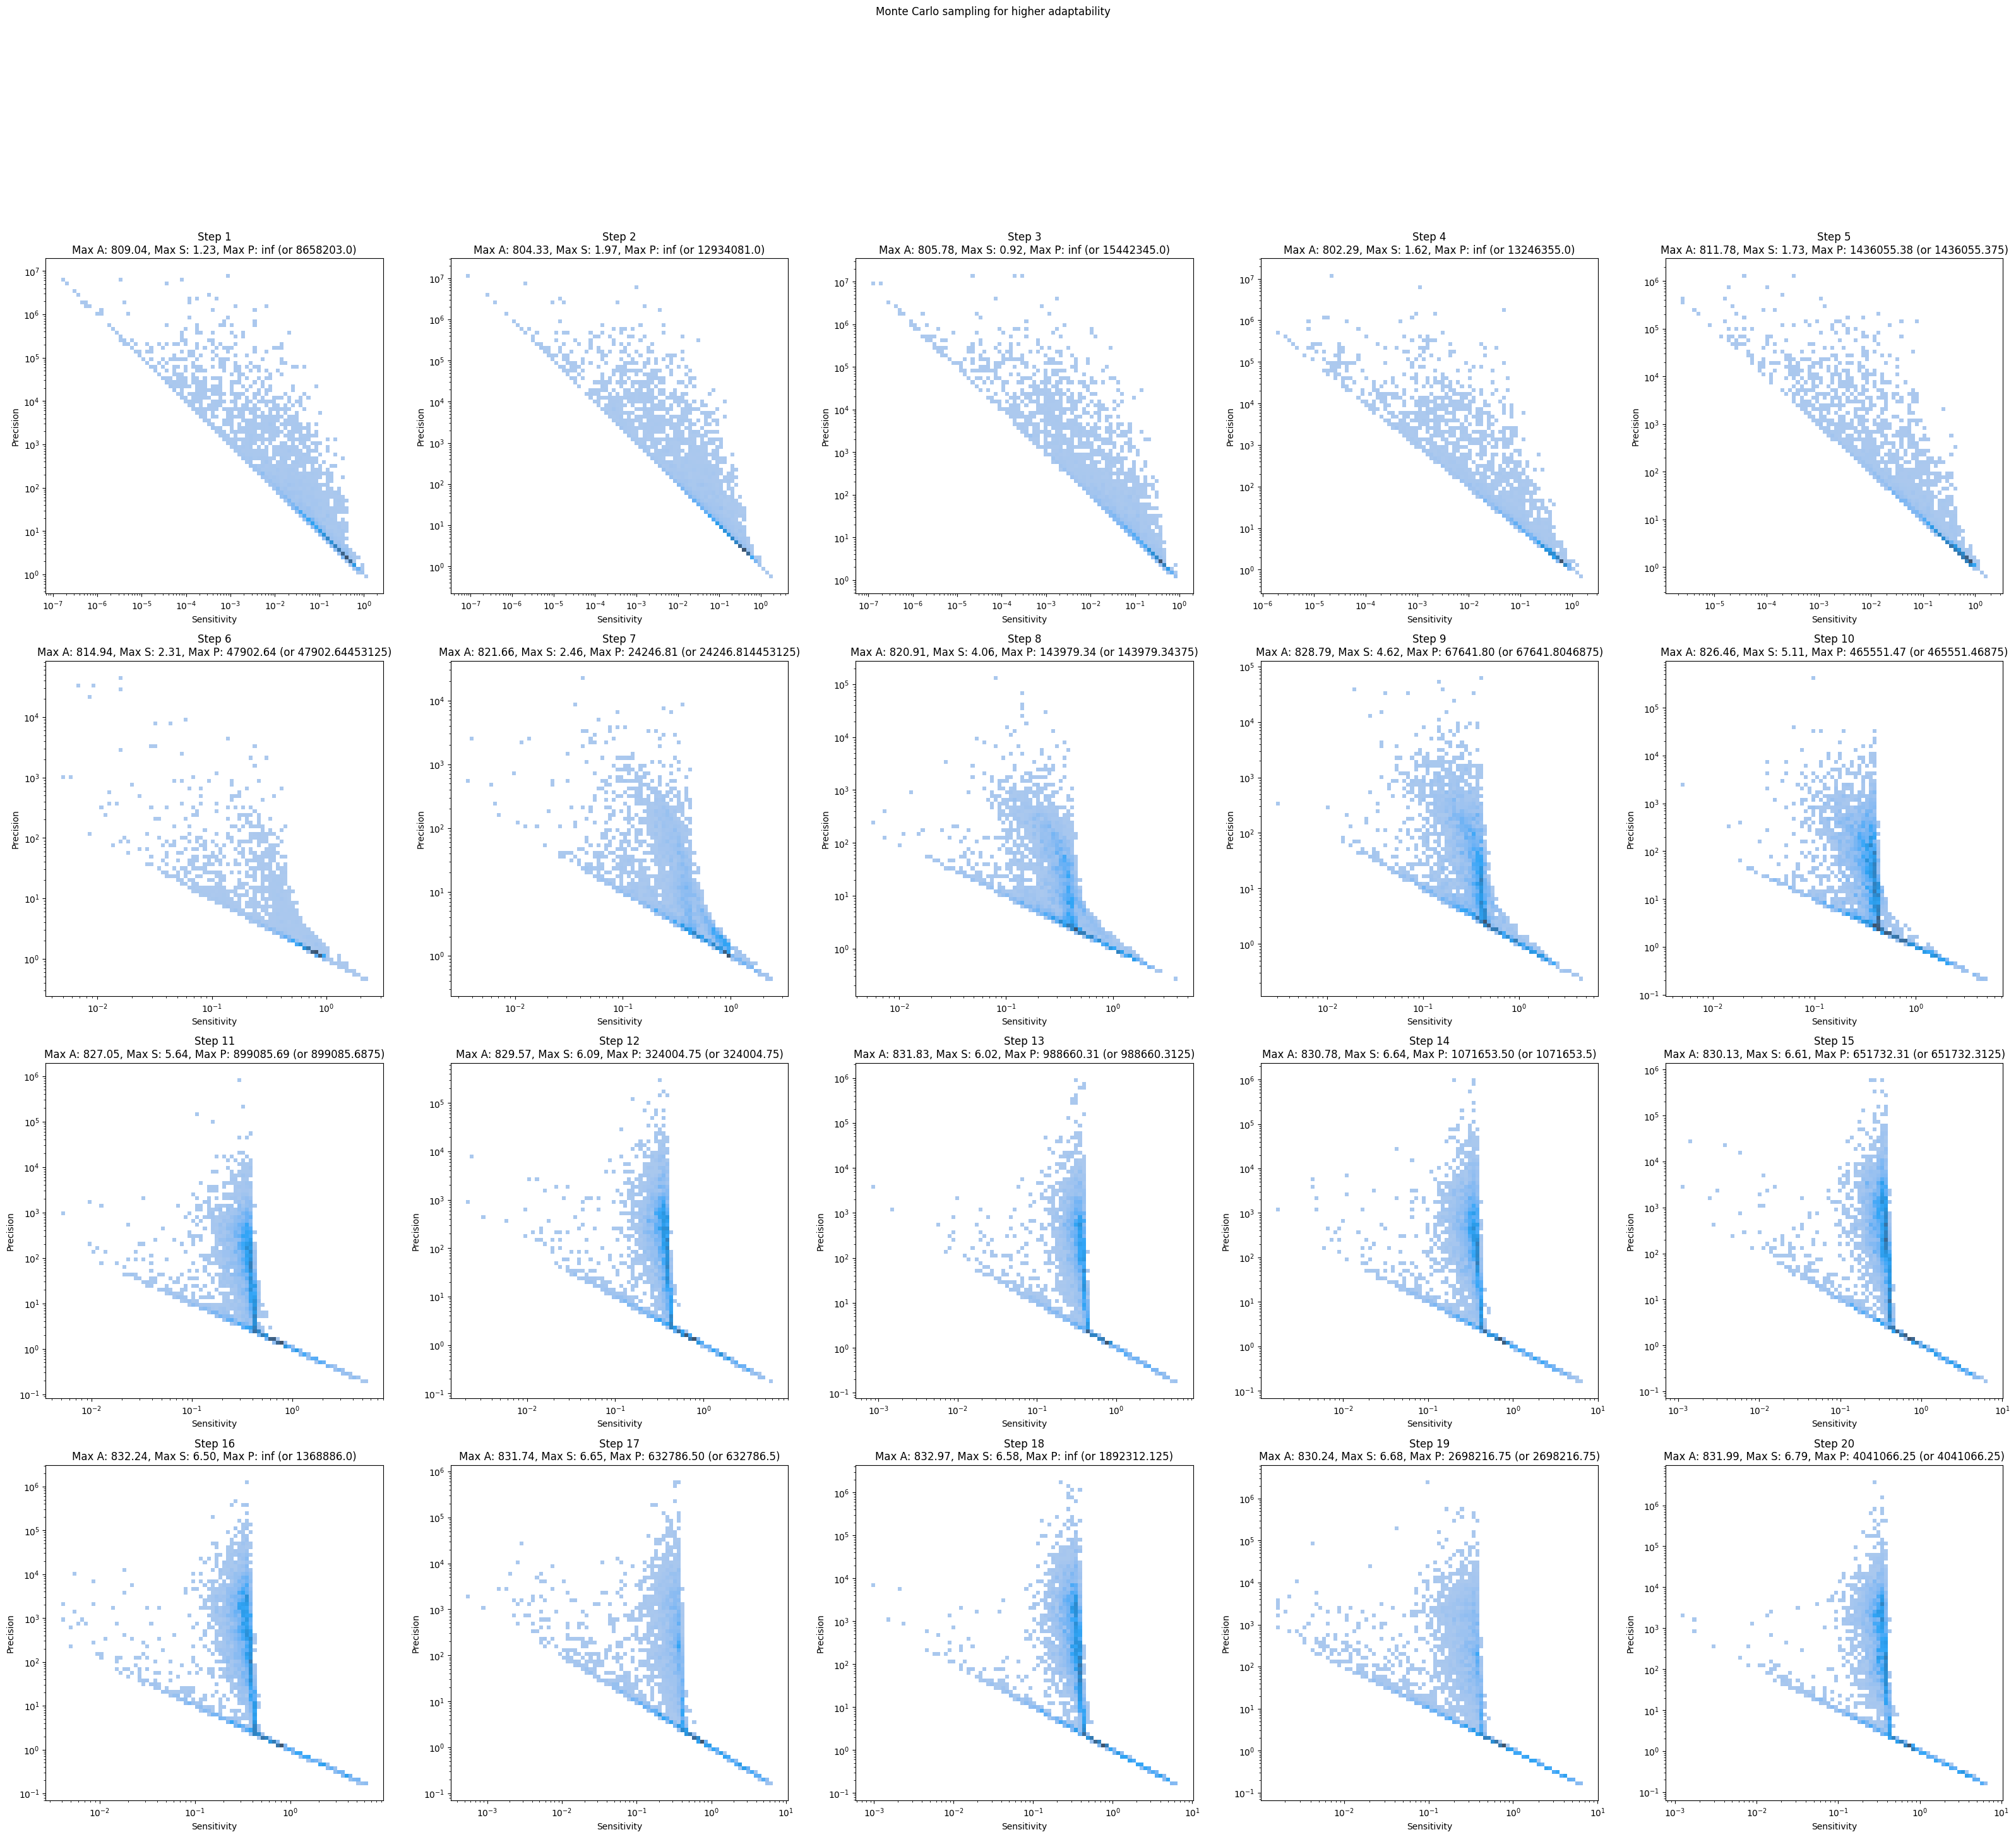

In [14]:
nc = int(np.ceil(np.sqrt(total_steps)))
nr = int(np.ceil(np.sqrt(total_steps)))
plt.figure(figsize=(8*nc, 8*nr))
# for step, (a, s, p) in enumerate(zip(all_adaptability, all_sensitivity, all_precision)):
for step in d['Step'].unique():
    filt = (d['Step'] == step) & (d['Species'].isin(species_output))
    
    print(f'Maxima - Adaptability: {np.nanmax(d[filt]["Adaptability"])}, Sensitivity: {np.nanmax(d[filt]["Sensitivity"])}, Precision: {np.nanmax(d[filt]["Precision"])}')
    
    ax = plt.subplot(nr, nc, step+1)
    # sns.scatterplot(d[filt], x='Sensitivity', y='Precision', hue='Adaptability', palette='viridis')
    # plt.xscale('log')
    # plt.yscale('log')
    sns.histplot(d[filt], x='Sensitivity', y='Precision', bins=80, log_scale=[True, True])
    plt.title(f'Step {step+1}\nMax A: {np.nanmax(d[filt]["Adaptability"]):.2f}, Max S: {np.nanmax(d[filt]["Sensitivity"]):.2f}, Max P: {np.nanmax(d[filt]["Precision"]):.2f} (or {np.nanmax(d[filt]["Precision"][d[filt]["Precision"] < np.inf])})')

plt.suptitle('Monte Carlo sampling for higher adaptability')

Text(0.5, 0.98, 'Monte Carlo sampling for higher adaptability')

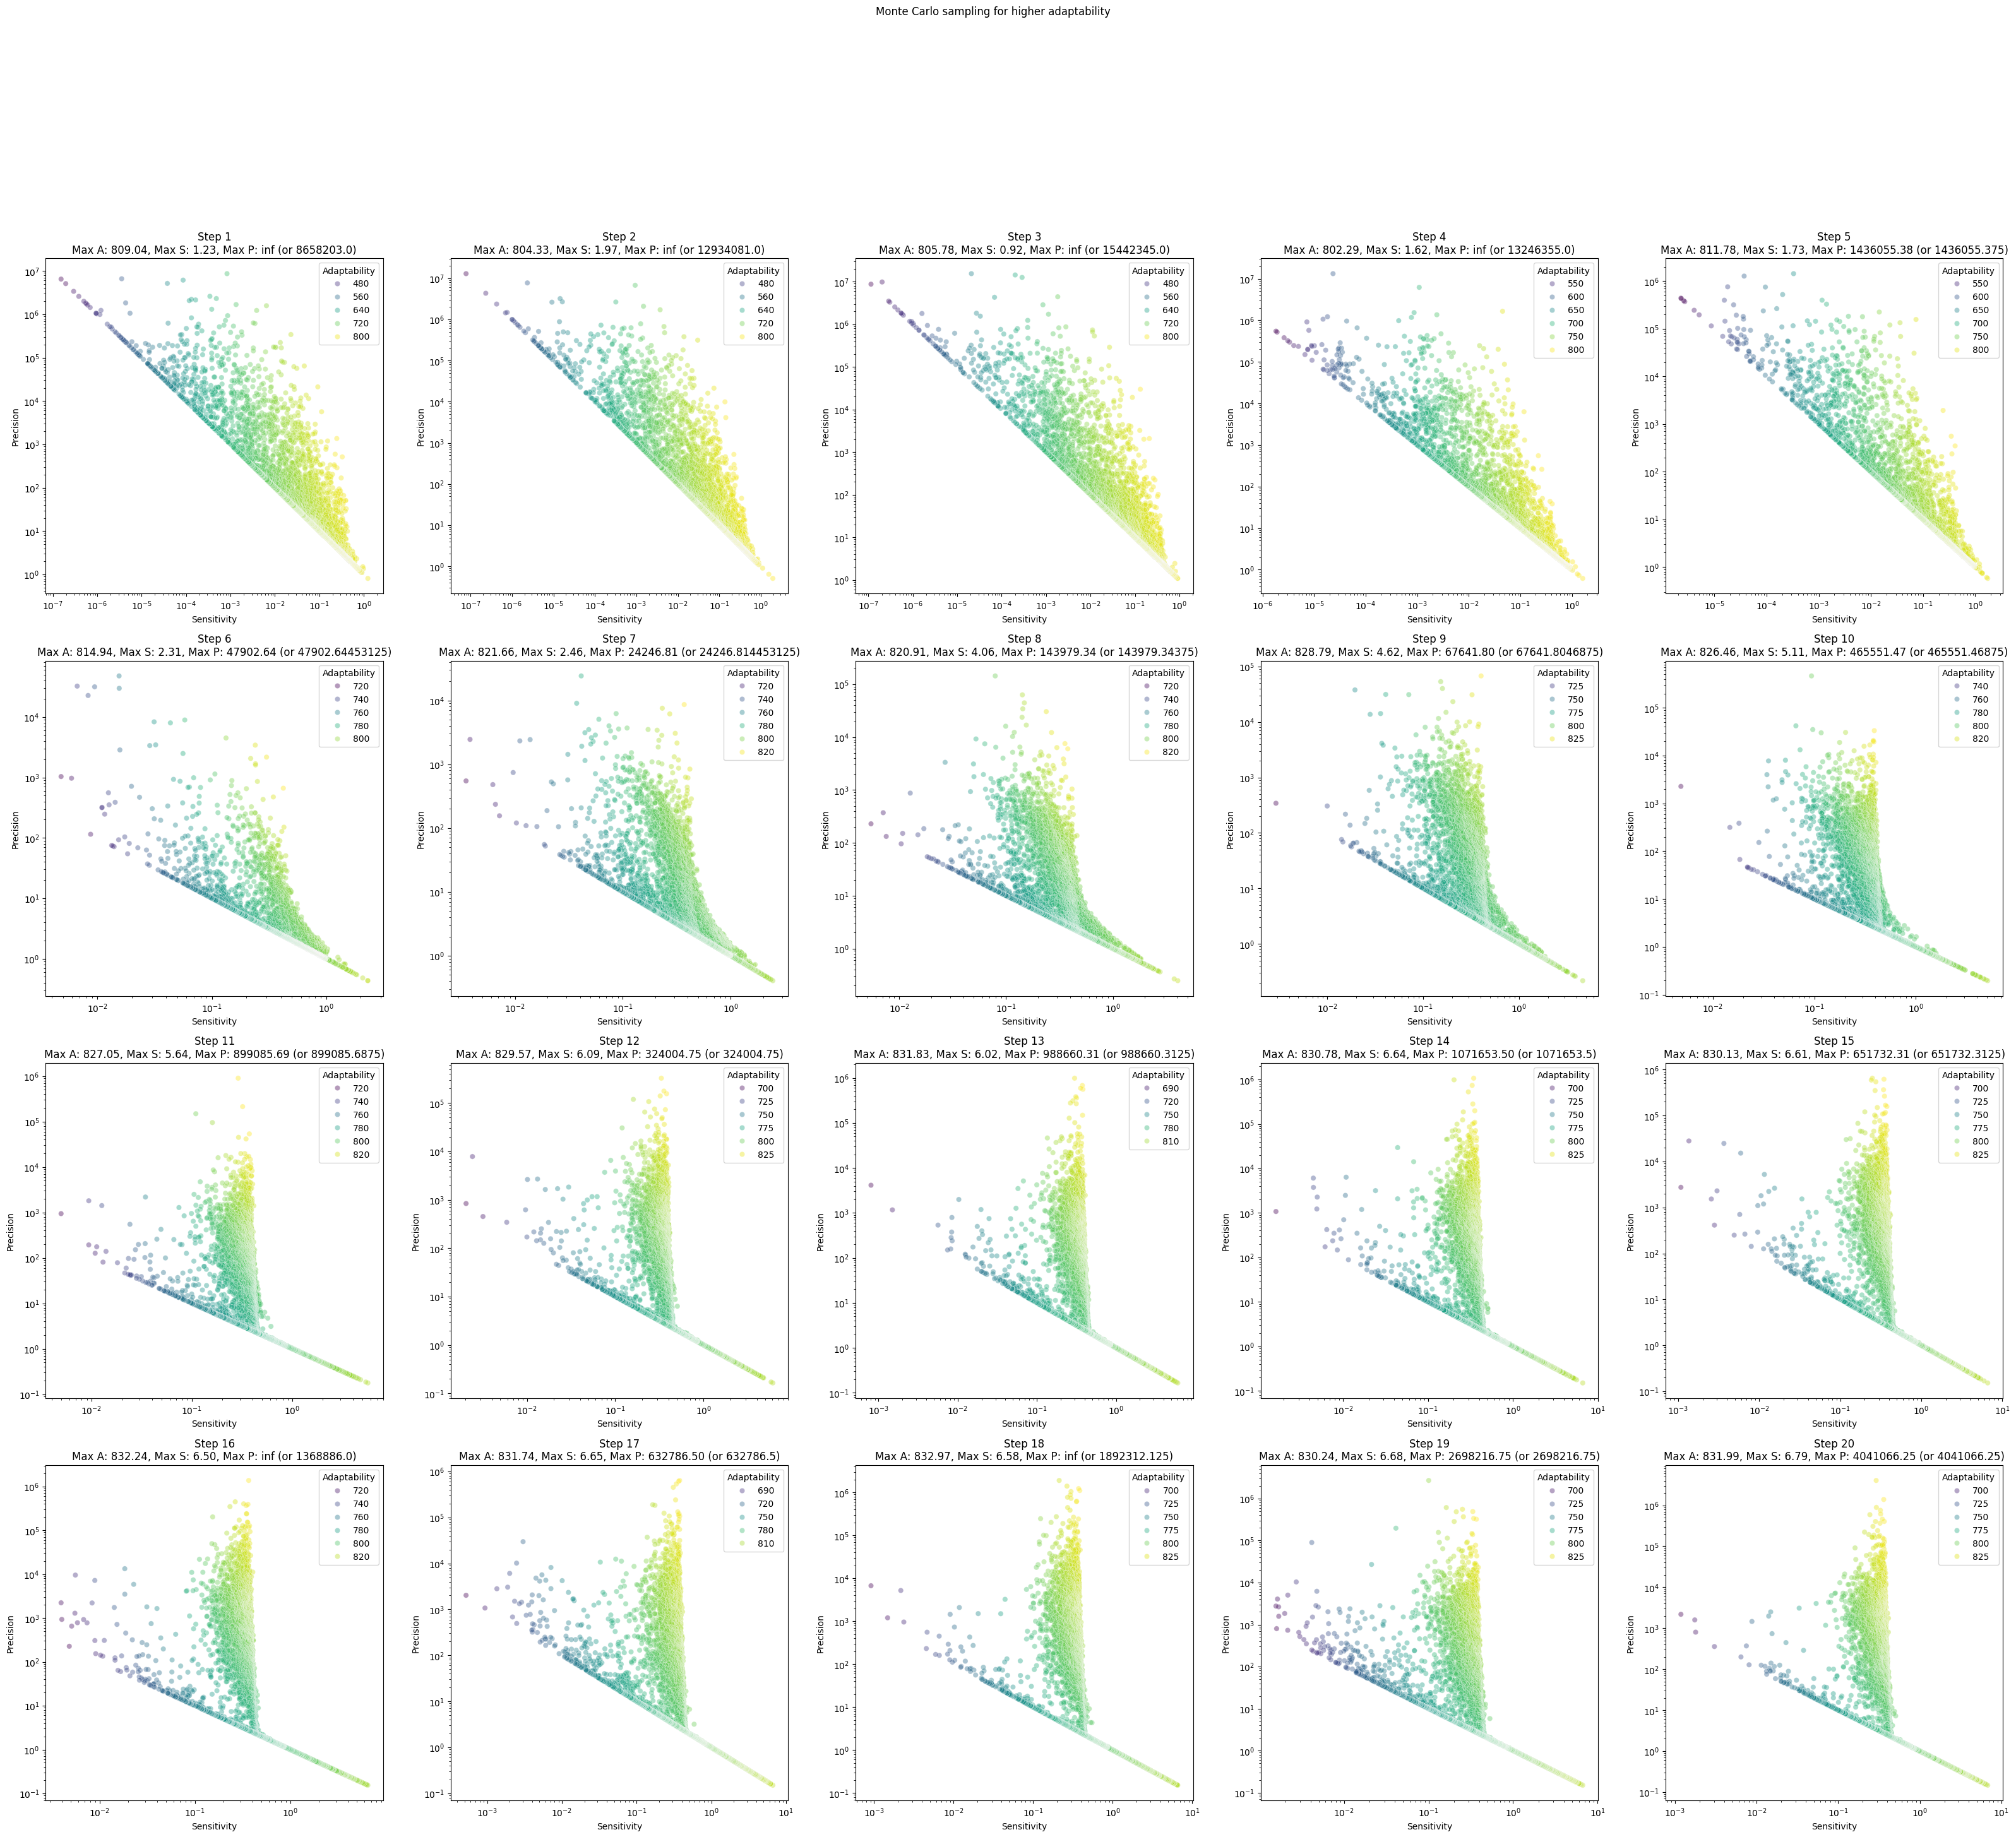

In [21]:
plt.figure(figsize=(8*nc, 8*nr))
for step in d['Step'].unique():
    filt = (d['Step'] == step) & (d['Species'].isin(species_output))
    
    ax = plt.subplot(nr, nc, step+1)
    sns.scatterplot(d[filt], x='Sensitivity', y='Precision', hue='Adaptability', palette='viridis', alpha=0.4)
    plt.xscale('log')
    plt.yscale('log')
    plt.title(f'Step {step+1}\nMax A: {np.nanmax(d[filt]["Adaptability"]):.2f}, Max S: {np.nanmax(d[filt]["Sensitivity"]):.2f}, Max P: {np.nanmax(d[filt]["Precision"]):.2f} (or {np.nanmax(d[filt]["Precision"][d[filt]["Precision"] < np.inf])})')

plt.suptitle('Monte Carlo sampling for higher adaptability')

Text(0.5, 0.98, 'Monte Carlo sampling for higher adaptability')

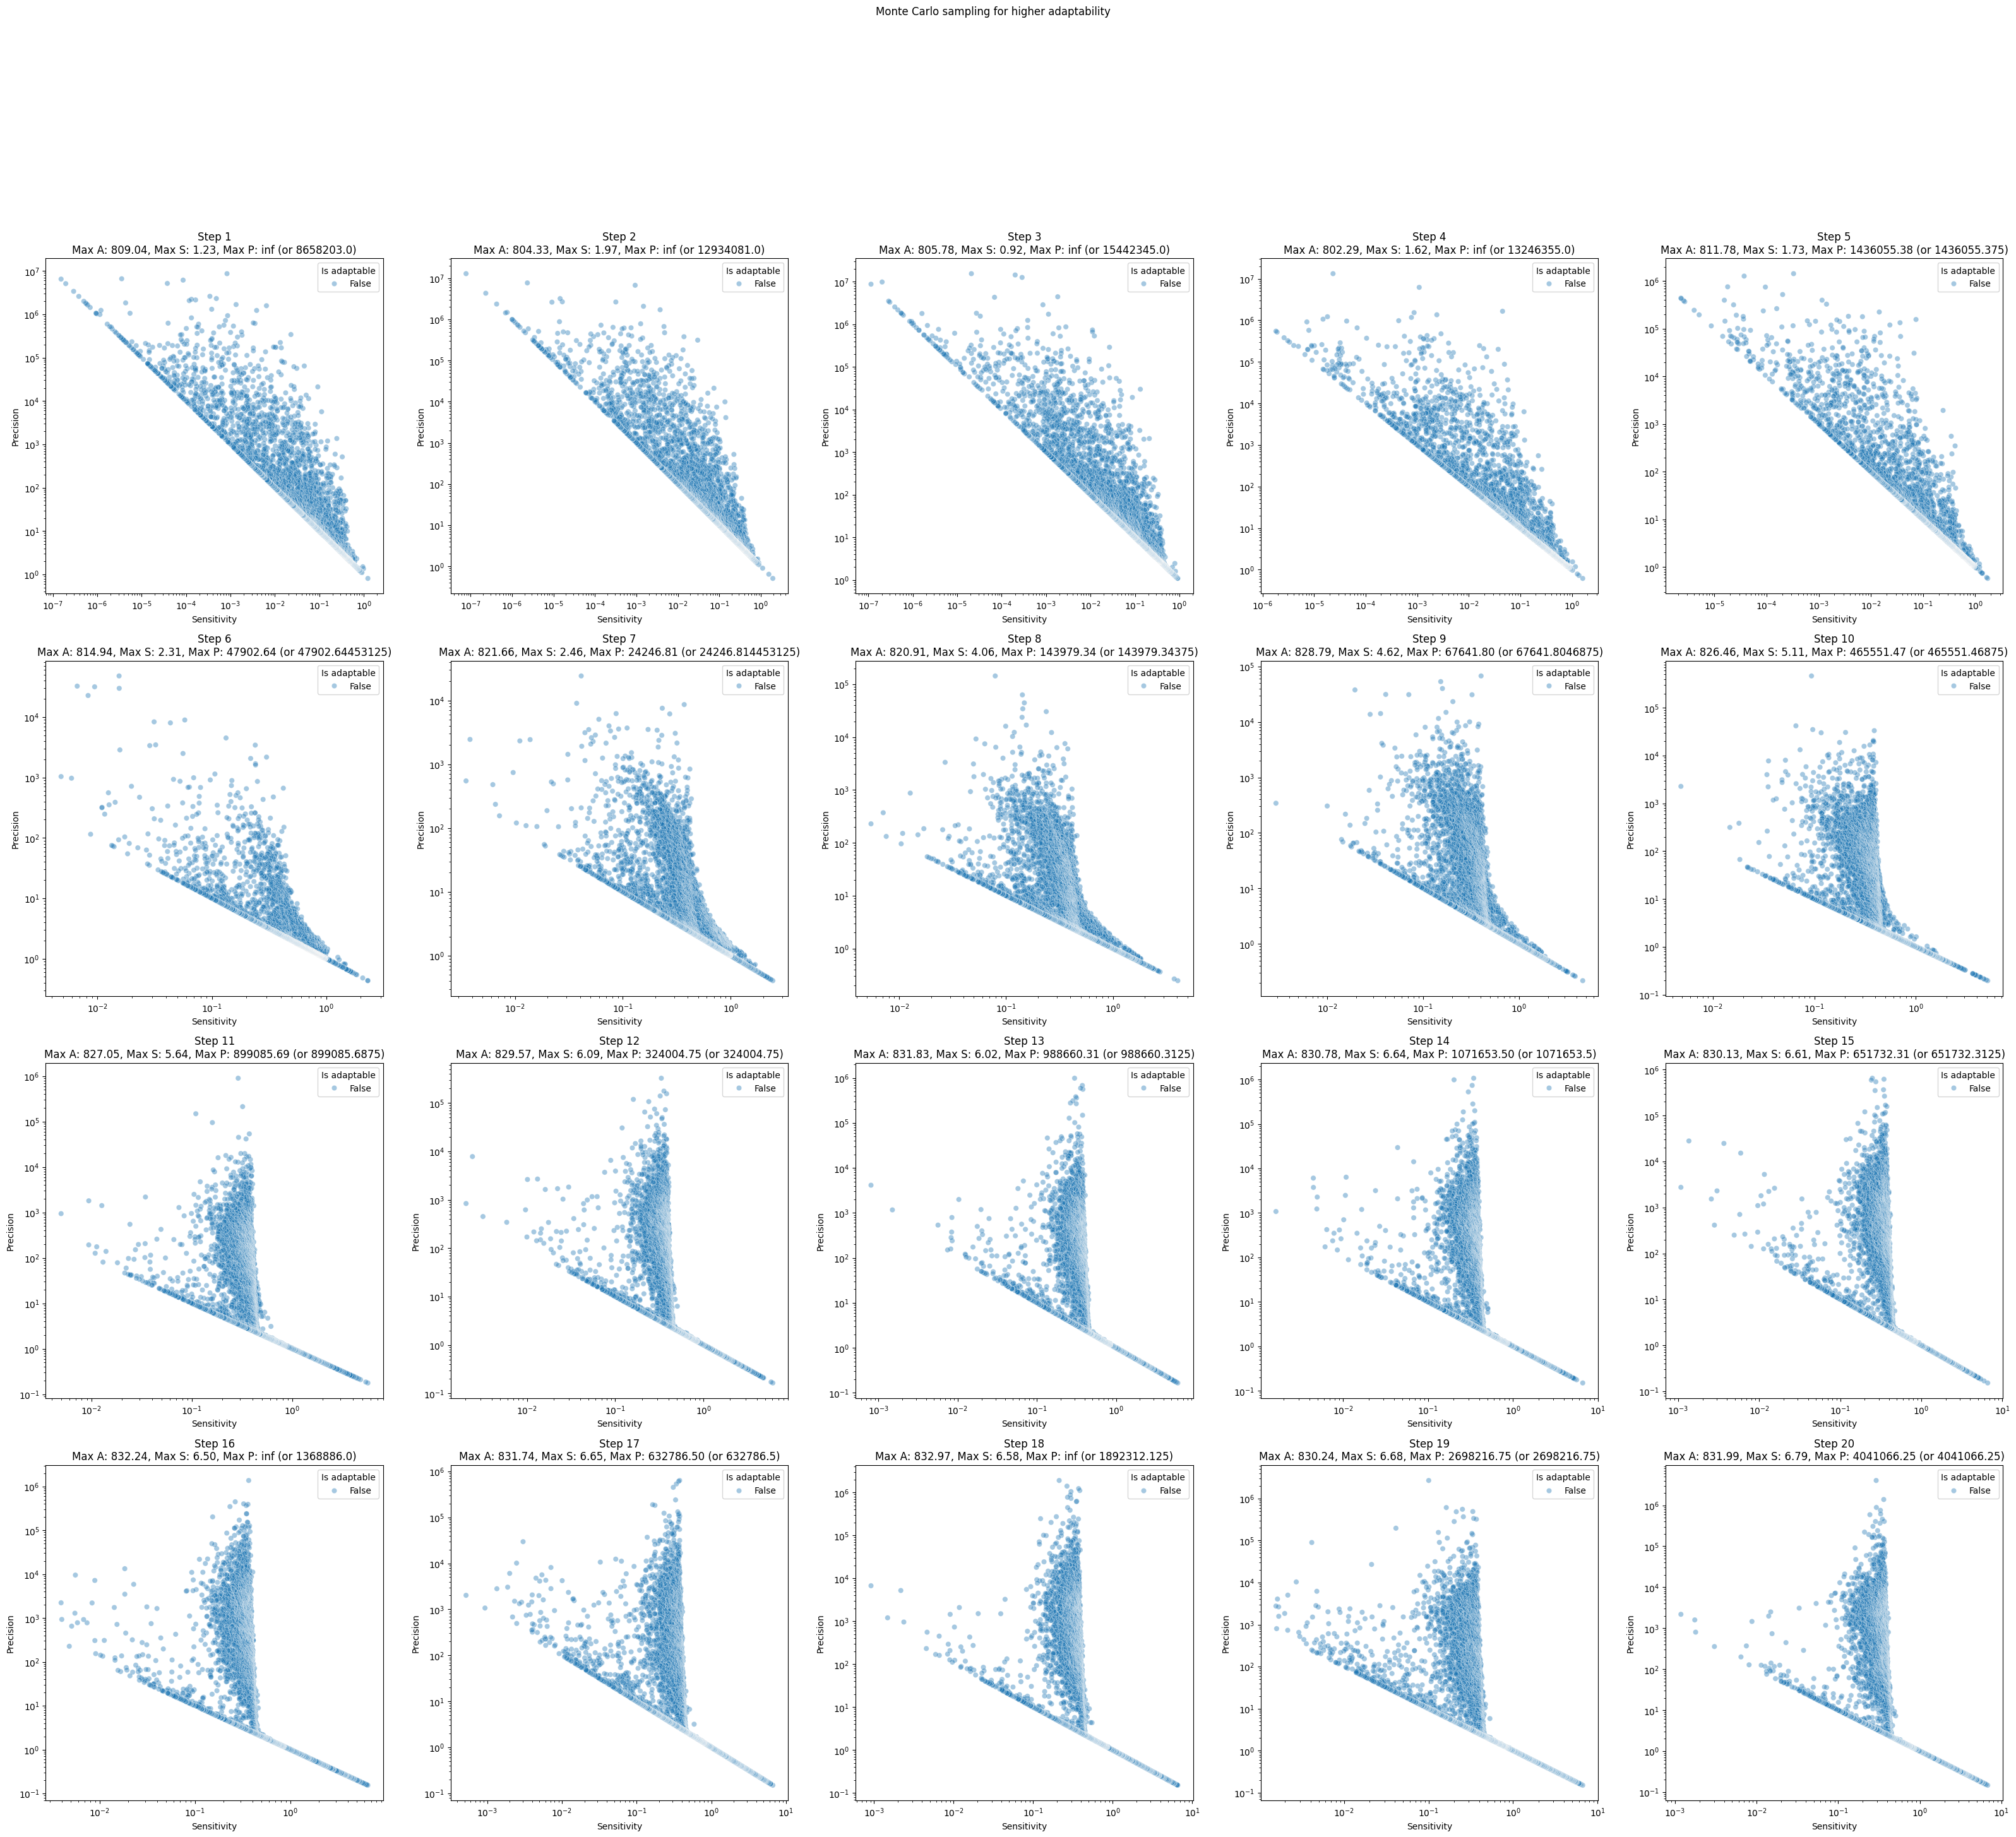

In [23]:
d['Is adaptable'] = (d['Sensitivity'] > 1e0) & (d['Precision'] > 1e1)
plt.figure(figsize=(8*nc, 8*nr))
for step in d['Step'].unique():
    filt = (d['Step'] == step) & (d['Species'].isin(species_output))
    
    ax = plt.subplot(nr, nc, step+1)
    sns.scatterplot(d[filt], x='Sensitivity', y='Precision', hue='Is adaptable', alpha=0.4)
    plt.xscale('log')
    plt.yscale('log')
    plt.title(f'Step {step+1}\nMax A: {np.nanmax(d[filt]["Adaptability"]):.2f}, Max S: {np.nanmax(d[filt]["Sensitivity"]):.2f}, Max P: {np.nanmax(d[filt]["Precision"]):.2f} (or {np.nanmax(d[filt]["Precision"][d[filt]["Precision"] < np.inf])})')

plt.suptitle('Monte Carlo sampling for higher adaptability')

Maxima - Adaptability: 832.96875, Sensitivity: 6.576821327209473, Precision: inf
Maxima - Adaptability: 832.2353515625, Sensitivity: 6.500379085540772, Precision: inf
Maxima - Adaptability: 831.9884033203125, Sensitivity: 6.793161869049072, Precision: 4041066.25
Maxima - Adaptability: 831.8274536132812, Sensitivity: 6.021985530853272, Precision: 988660.3125
Maxima - Adaptability: 831.74072265625, Sensitivity: 6.648133754730225, Precision: 632786.5
Maxima - Adaptability: 830.7763061523438, Sensitivity: 6.639476776123047, Precision: 1071653.5
Maxima - Adaptability: 830.2384643554688, Sensitivity: 6.679690361022949, Precision: 2698216.75
Maxima - Adaptability: 830.126708984375, Sensitivity: 6.605347633361816, Precision: 651732.3125
Maxima - Adaptability: 829.5709228515625, Sensitivity: 6.087036609649658, Precision: 324004.75
Maxima - Adaptability: 828.7918701171875, Sensitivity: 4.620964050292969, Precision: 67641.8046875
Maxima - Adaptability: 827.0521240234375, Sensitivity: 5.6398720741

Text(0.5, 0.98, 'Monte Carlo sampling for higher adaptability')

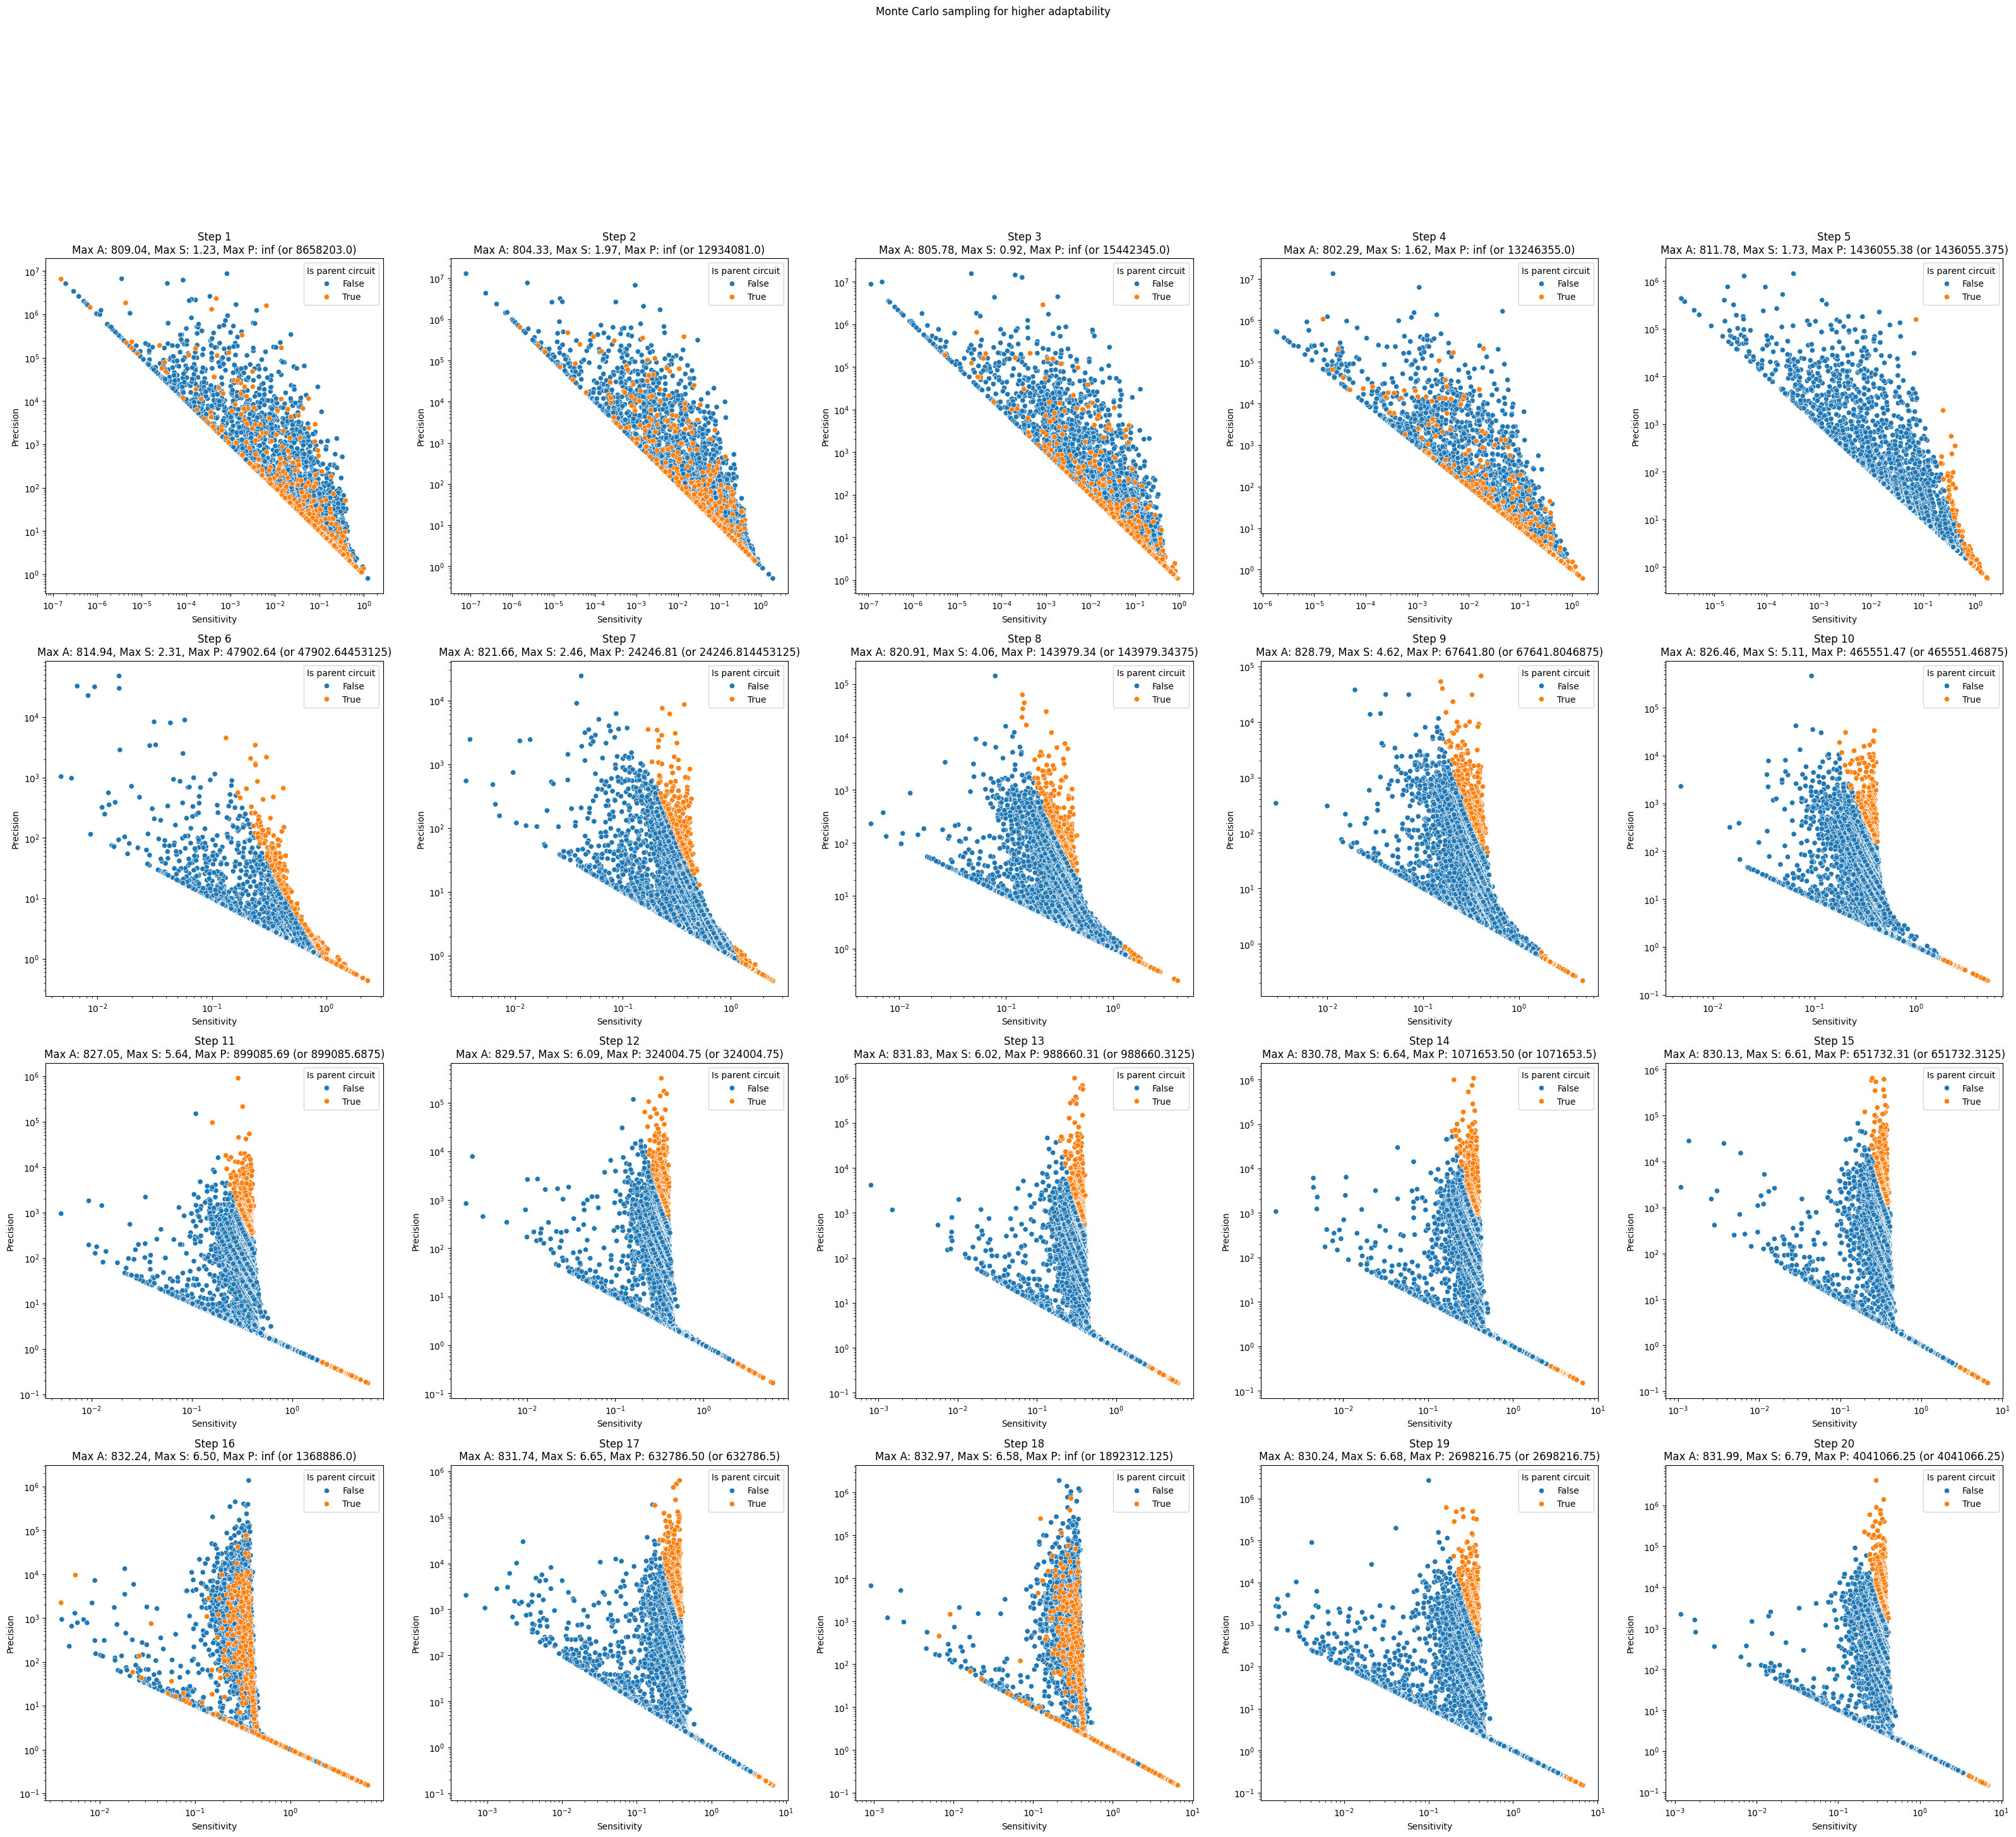

In [15]:
plt.figure(figsize=(8*nc, 8*nr))
for step in d['Step'].unique():
    filt = (d['Step'] == step) & (d['Species'].isin(species_output))
    ax = plt.subplot(nr, nc, step+1)
    sns.scatterplot(d[filt].sort_values(by='Is parent circuit'), x='Sensitivity', y='Precision', hue='Is parent circuit')
    plt.xscale('log')
    plt.yscale('log')
    plt.title(f'Step {step+1}\nMax A: {np.nanmax(d[filt]["Adaptability"]):.2f}, Max S: {np.nanmax(d[filt]["Sensitivity"]):.2f}, Max P: {np.nanmax(d[filt]["Precision"]):.2f} (or {np.nanmax(d[filt]["Precision"][d[filt]["Precision"] < np.inf])})')

plt.suptitle('Monte Carlo sampling for higher adaptability')

## Visualise histograms

Text(0.5, 1.0, 'Precision')

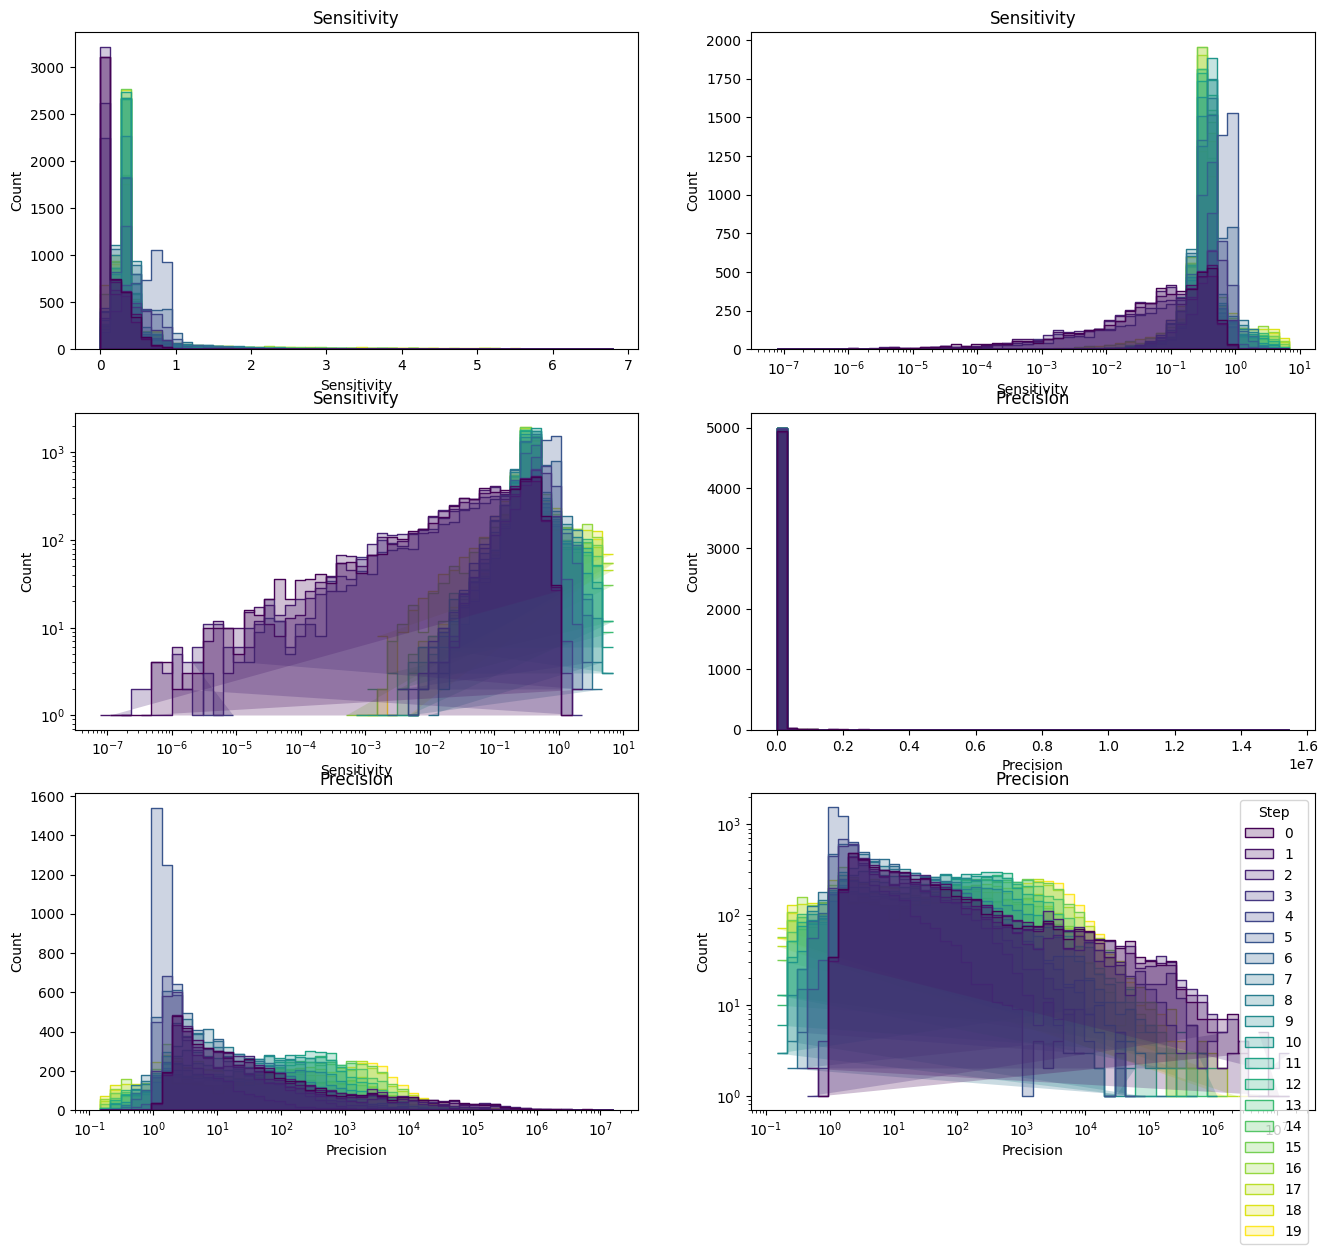

In [17]:
fig = plt.figure(figsize=(8*2, 7*2))
ax = plt.subplot(3, 2, 1)
sns.histplot(d[d['Species'].isin(species_output)], x='Sensitivity', hue='Step', log_scale=[False, False], bins=50, element='step', palette='viridis', legend=False)
plt.title('Sensitivity')
ax = plt.subplot(3, 2, 2)
sns.histplot(d[d['Species'].isin(species_output)], x='Sensitivity', hue='Step', log_scale=[True, False], bins=50, element='step', palette='viridis', legend=False)
plt.title('Sensitivity')
ax = plt.subplot(3, 2, 3)
sns.histplot(d[d['Species'].isin(species_output)], x='Sensitivity', hue='Step', log_scale=[True, True], bins=50, element='step', palette='viridis', legend=False)
plt.title('Sensitivity')
ax = plt.subplot(3, 2, 4)
sns.histplot(d[d['Species'].isin(species_output)], x='Precision', hue='Step', log_scale=[False, False], bins=50, element='step', palette='viridis', legend=False)
plt.title('Precision')
ax = plt.subplot(3, 2, 5)
sns.histplot(d[d['Species'].isin(species_output)], x='Precision', hue='Step', log_scale=[True, False], bins=50, element='step', palette='viridis', legend=False)
plt.title('Precision')
ax = plt.subplot(3, 2, 6)
sns.histplot(d[d['Species'].isin(species_output)], x='Precision', hue='Step', log_scale=[True, True], bins=50, element='step', palette='viridis', legend=True)
plt.title('Precision')


In [18]:
d.sort_values(by='Adaptability', ascending=False).head(10)

Adaptability  Sensitivity     Precision  Is parent circuit  Circuit idx  \
0    832.968750     0.385321  1.105555e+06              False         4451   
1    832.437378     0.372425  1.224135e+06              False         4445   
2    832.235352     0.366005  1.368886e+06              False         3751   
3    831.988403     0.361070  1.387826e+06               True         4824   
4    831.827454     0.381413  5.612324e+05               True         3137   
5    831.802307     0.375272  6.818147e+05               True         3203   
6    831.740723     0.376194  6.327865e+05               True         4172   
7    831.134583     0.365686  6.086739e+05               True         4037   
8    830.776306     0.344814  1.071654e+06               True         3499   
9    830.617065     0.356744  5.936438e+05               True         3172   

  Species  Step                                      Params energy  \
0   RNA_2    17  [-2.490243673324585, -2.3685407638549805, -11....   
1   RNA_2    17  [-1.010116457939148, -2.05387020111084, -11.48...   
2   RNA_2    15  [-0.9613144993782043, -2.7310869693756104, -11...   
3   RNA_2    19  [-1.8473610877990723, -1.2901220321655273, -11...   
4   RNA_2    12  [-1.1668790578842163, -3.0316648483276367, -11...   
5   RNA_2    12  [-1.4184926748275757, -2.8464436531066895, -11...   
6   RNA_2    16  [-1.9835503101348877, -1.5860093832015991, -11...   
7   RNA_2    16  [-1.1161882877349854, -1.6135954856872559, -11...   
8   RNA_2    13  [-0.9576665163040161, -1.7326295375823975, -10...   
9   RNA_2    12  [-1.7788689136505127, -3.0535519123077393, -10...   

                        Params equilibrium constants  \
0  [1.2297405191930011e-05, 1.1156538676004857e-0...   
1  [3.76326238438196e-06, 8.673645425005816e-06, ...   
2  [3.61916841029597e-06, 1.4910451682226267e-05,...   
3  [7.352804004767677e-06, 4.708128471975215e-06,...   
4  [4.2660826693463605e-06, 1.896366484288592e-05...   
5  [5.217335910856491e-06, 1.635196531424299e-05,...   
6  [8.1991729530273e-06, 5.965543550701113e-06, 0...   
7  [4.096543761988869e-06, 6.098665835452266e-06,...   
8  [3.608622364481562e-06, 6.707972715958022e-06,...   
9  [6.960754944884684e-06, 1.929863174154889e-05,...   

                                        Params rates  
0  [122.75605773925781, 135.30908203125, 0.074375...  
1  [401.13623046875, 174.0422821044922, 0.0916659...  
2  [417.1071472167969, 101.2431411743164, 0.13191...  
3  [205.3068389892578, 320.6329345703125, 0.09322...  
4  [353.8564758300781, 79.6038589477539, 0.083325...  
5  [289.33941650390625, 92.3180160522461, 0.11328...  
6  [184.11380004882812, 253.050048828125, 0.06237...  
7  [368.5011291503906, 247.5264129638672, 0.10909...  
8  [418.32611083984375, 225.04281616210938, 0.139...  
9  [216.87030029296875, 78.22217559814453, 0.1658...